# References
## Thanks to the authors of notebooks
+ [NOOB1541](https://www.kaggle.com/code/dhk13491/gislr-simple-pytorch-to-tflite-baseline)
+ [ROBERT HATCH](https://www.kaggle.com/code/roberthatch/gislr-feature-data-on-the-shoulders)

---

## Our github links
+  💜 [PiroJOJO](https://github.com/PiroJOJO)
+ 🚀 [HerrPhoton](https://github.com/HerrPhoton)
+ 🍺 [Andrey-kvasik](https://github.com/kvasik3000)

### And our repository [https://github.com/HerrPhoton/Sign_Language_Recognition](https://github.com/HerrPhoton/Sign_Language_Recognition)

# Install library

In [ ]:
%pip install tflite_runtime
%pip install onnxsim
%pip install onnx_tf
%pip install mediapipe

# Imports library

In [6]:
import onnxsim
import shutil
import torch
import onnx
import json
import copy
import cv2
import os

import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import torch.optim as optim
import tensorflow as tf
import mediapipe as mp
import torch.nn as nn
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
#from onnx_tf.backend import prepare
from datetime import timedelta
from torchinfo import summary 
from tqdm import tqdm, trange
from tqdm import tqdm
from glob import glob

# Settings

In [7]:
PATH = '/kaggle/input/gislr-feature-data-on-the-shoulders'

# File directories
DATA_DIR       = '/kaggle/input/asl-signs/'
LANDMARK_FILES = 'train_landmark_files'
CSV_FILE       = 'train.csv'
ID_TO_SIGN_MAP = 'sign_to_prediction_index_map.json'

#Dataset settings
VAL_PART    = 0.1
TEST_PART   = 0.1
BATCH_SIZE  = 128
NUM_CLASSES = 250
MAX_ROWS    = 543 # Face - 468, Pose - 33, Hands - 21
MAX_FRAMES  = 20
SHUFFLE     = True
NUM_WORKERS = 0
PIN_MEMORY  = False

# Training settings
PRETRAINING = False
LR           = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS   = 500

# Scheduler settings
T_0     = 1
T_MULT  = 2
ETA_MIN = 5e-5

# Distribution of classes in the dataset

In [ ]:
parquets = pd.read_csv(os.path.join(DATA_DIR, CSV_FILE))
parquets.head()

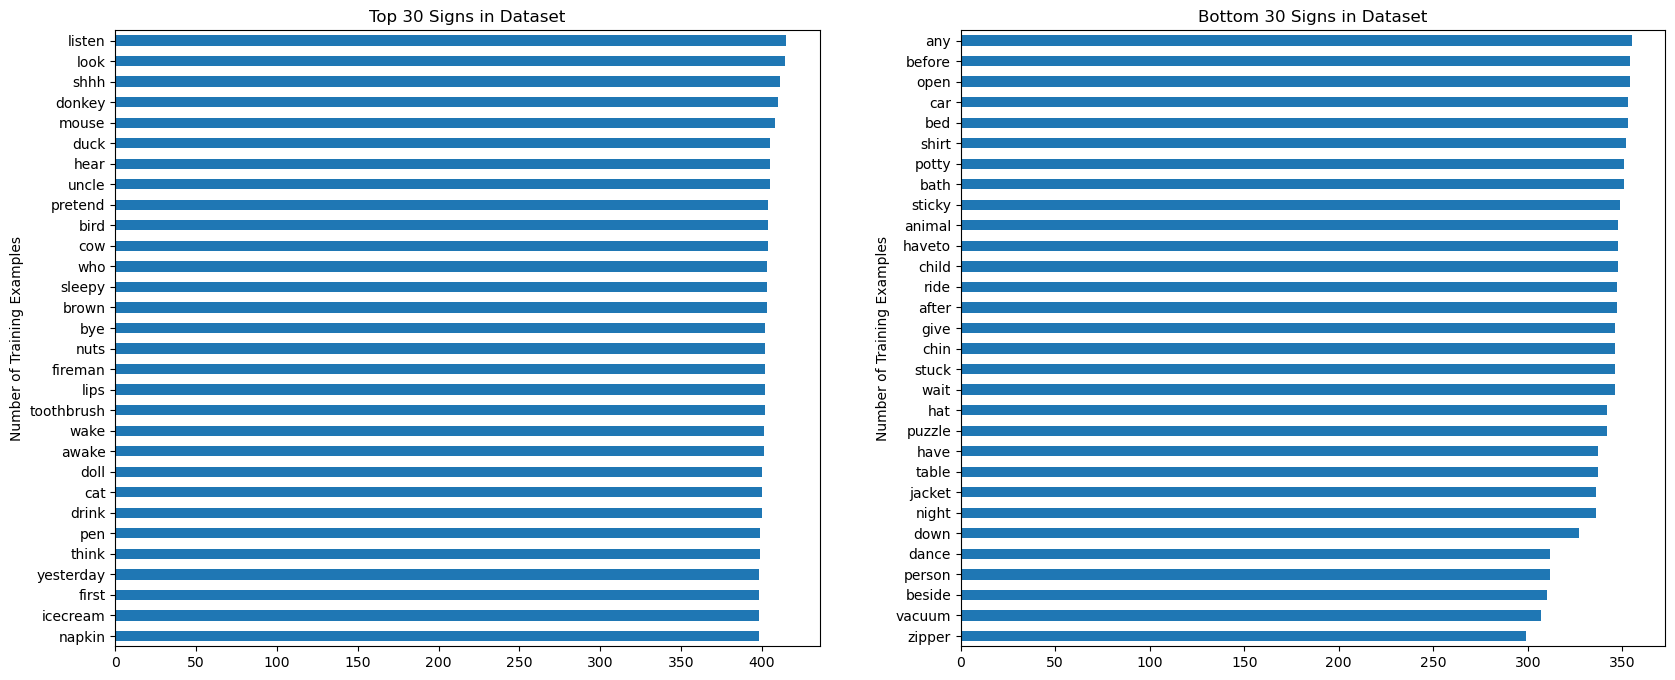

In [5]:
NUM_2_SHOW = 30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

parquets['sign'].value_counts().head(NUM_2_SHOW).sort_values(ascending = True).plot(
    kind = "barh", title = f'Top {NUM_2_SHOW} Signs in Dataset', xlabel = 'Number of Training Examples', ylabel = '', ax = ax1)

parquets['sign'].value_counts().tail(NUM_2_SHOW).sort_values(ascending = True).plot(
    kind = "barh", title = f'Bottom {NUM_2_SHOW} Signs in Dataset', xlabel = 'Number of Training Examples', ylabel = '', ax = ax2)

plt.show()

# Class indexes

In [6]:
def read_json(path):
    
    with open(path, "r") as file:
        json_data = json.load(file)
        
    return json_data

In [7]:
sign_2_id_map = read_json(os.path.join(DATA_DIR, ID_TO_SIGN_MAP))
id_2_sign_map = {id: sign for sign, id in sign_2_id_map.items()}

In [8]:
parquets['id'] = parquets["sign"].map(lambda sign: sign_2_id_map[sign])
parquets.head()

,path,participant_id,sequence_id,sign,id
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


# Landmark data example

In [9]:
EXAMPLE_SIGN  = 'shhh'

lms = parquets.query(f'sign == "{EXAMPLE_SIGN}"')['path'].values[0]
lms = pq.read_table(os.path.join(DATA_DIR, lms)).to_pandas()

lms.head()

,frame,row_id,type,landmark_index,x,y,z
0,14,14-face-0,face,0,0.432380,0.375417,-0.044000
1,14,14-face-1,face,1,0.437980,0.349091,-0.070176
2,14,14-face-2,face,2,0.429624,0.360922,-0.040331
3,14,14-face-3,face,3,0.430260,0.315678,-0.049688
4,14,14-face-4,face,4,0.441155,0.338613,-0.073218


# Frames per file

In [10]:
if os.path.isfile('/kaggle/input/frames-per-file/frames_per_file.txt'):
    with open('/kaggle/input/frames-per-file/frames_per_file.txt', 'r') as file:

        frames = file.read()
        frames = frames.split()
        frames = list(map(int, frames))

        parquets['n_frames'] = frames

else: 
    frames = np.zeros(len(parquets), dtype = 'int32')

    for i in tqdm(range(len(parquets))):
        frms = pq.read_table(os.path.join(DATA_DIR, parquets.iloc[i]['path']), columns = ['frame']).to_pandas()
        frames[i] = len(pd.unique(frms.squeeze()))

    with open('/kaggle/input/frames-per-file/frames_per_file.txt', 'w') as file:
        for val in frames:
            file.write(str(val))
            file.write(' ')

parquets['n_frames'] = frames
parquets.head()

,path,participant_id,sequence_id,sign,id,n_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,23
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,11
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,105
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,12
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,18


# Visualization of Landmarks

In [11]:
def show_frame(df, label, frame_id):
    
    df = df.dropna()
    
    fig, axs = plt.subplots(1, 4, figsize = (24, 6))
    frame = df[df['frame'] == frame_id]

    hands_edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]
    
    pose_edges = [(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), 
                  (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), 
                  (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28),
                  (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)]

    for ax, type in zip(axs, ["face", "pose", "right_hand", "left_hand"]):
        
        lm = frame.query(f'type == "{type}"')

        ax.set_title(type, fontsize = 15)
        ax.scatter(lm['x'], -lm['y'])

        xs     = lm['x'].values
        ys     = lm['y'].values
        lm_ids = lm['landmark_index'].values

        for x, y, id in zip(xs, ys, lm_ids):
            ax.text(x, -y, id, fontsize = 6)

        if (type == 'right_hand' or type == 'left_hand') and len(xs) > 0:
            for edge in hands_edges:
                ax.plot([xs[edge[0]], xs[edge[1]]], [-ys[edge[0]], -ys[edge[1]]], color = 'salmon')

        elif type == 'pose':
            for edge in pose_edges:
                ax.plot([xs[edge[0]], xs[edge[1]]], [-ys[edge[0]], -ys[edge[1]]], color = 'salmon')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.suptitle(f'Sign: "{label}", Frame: {frame_id}', fontsize = 20)

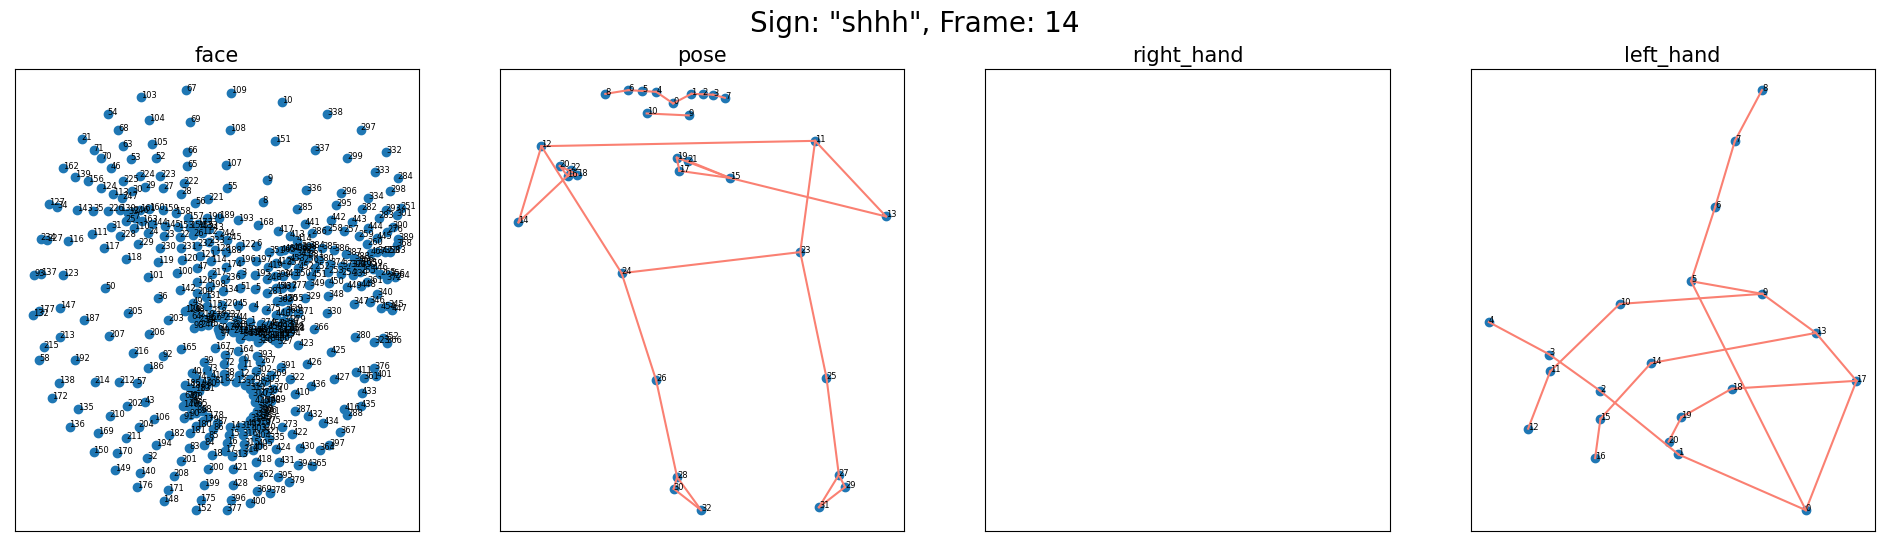

In [12]:
def show_frames_seq(df, label, start_frame, n_frames):

    frames = np.linspace(start_frame, start_frame + n_frames, n_frames, dtype = int, endpoint = True)

    for i in range(n_frames):
        show_frame(df, label, frames[i])
        
    plt.show()

show_frames_seq(lms, EXAMPLE_SIGN, lms['frame'][0], 1)

# Creating a dataset

In [13]:
class PreprocessedGISLDataset(Dataset):
    def __init__(self, path) -> None:
        super().__init__()
        
        self.dataset = np.load(os.path.join(path, "feature_data.npy"))
        self.labels = np.load(os.path.join(path, "feature_labels.npy"))
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx, :], self.labels[idx]


# Creating a Dataloader

In [14]:
dataset = PreprocessedGISLDataset(PATH)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.9)
validation_size = dataset_size - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
data_loader = {
    'train':
       DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True),
    'valid':
         DataLoader(validation_dataset, batch_size=64, shuffle=True, drop_last=True)

}

# train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
# validation_dataset = DataLoader(validation_dataset, batch_size=64, shuffle=True, drop_last=True)

# Creating a model

In [15]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.in_feature = 5796
        self._1_feature = 1024
        self._2_feature = 512
        self.out_feature = 250

        self.l1 = nn.Sequential(nn.Linear(self.in_feature, self._1_feature),
                               nn.BatchNorm1d(self._1_feature),
                               nn.ReLU(),
                                nn.Dropout(p=0.4),
                               )
        
        self.l2 = nn.Sequential(nn.Linear(self._1_feature, self._2_feature),
                               nn.BatchNorm1d(self._2_feature),
                               nn.ReLU(),
                                nn.Dropout(p=0.4),
                               )
        
        self.l3 = nn.Sequential(nn.Linear(self._2_feature, self.out_feature),
                               nn.BatchNorm1d(self.out_feature),
                               nn.ReLU(),
                                nn.Dropout(p=0.4),
                               )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        out = self.l1(input)
        out = self.l2(out)
        out = self.l3(out)
        out = self.softmax(out)
        return out

# Selecting a device for training

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", DEVICE)
model = SimpleNet().to(DEVICE)

Current device: cuda


# Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=100,last_epoch=-1,verbose=False)


train_losses = []
val_losses   = []
train_accuracy    = []
val_accuracy      = []

lr = [LR]

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(NUM_EPOCHS):

    train_loss = 0
    train_acc = 0
    num_iter = 0
    model.train()
    for x, y in tqdm(data_loader['train'], leave = False):
        num_iter+=1
        pred = model(x.to(torch.float32).to(DEVICE))
        loss = criterion(pred.to(torch.float32), y.type(torch.LongTensor).to(DEVICE))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = pred.max(1).indices
        train_loss += loss.item()
        train_acc+=(torch.sum(pred.cpu() == y) / x.shape[0])
        
    lr_scheduler.step()
    lr.append(optimizer.param_groups[0]["lr"])
    
    train_losses.append(train_loss/num_iter)
    train_accuracy.append(train_acc/num_iter*100)
    tqdm.write(f"Training Loss for epoch {epoch+1}: {train_loss/num_iter:.3f}")
    tqdm.write(f"Training Acc for epoch {epoch+1}: {train_acc/num_iter*100:.3f}%")

    val_loss = 0
    val_acc = 0
    num_iter = 0
    model.eval()
    for x, y in data_loader['valid']:
        num_iter+=1
        pred = model(x.to(DEVICE).to(torch.float32))
        loss = criterion(pred.to(torch.float32), y.type(torch.LongTensor).to(DEVICE))
        
        pred = pred.max(1).indices
        val_loss += loss.item()
        val_acc+=(torch.sum(pred.cpu() == y) / x.shape[0])
    val_acc = val_acc/num_iter*100
    val_losses.append(val_loss/num_iter)
    val_accuracy.append(val_acc)
    if best_acc < val_acc: 
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, '/kaggle/working/best_model.pth')
    tqdm.write(f"Validation Loss for epoch {epoch+1}: {val_loss/num_iter:.3f}")
    tqdm.write(f"Validation Acc for epoch {epoch+1}: {val_acc:.3f}%")

model.load_state_dict(torch.load('./best_model.pth'))

# Graphs

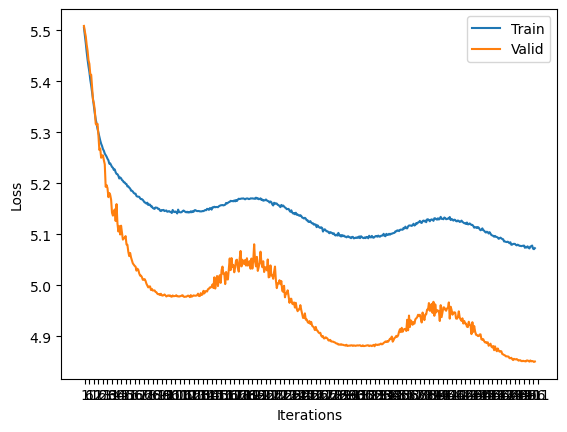

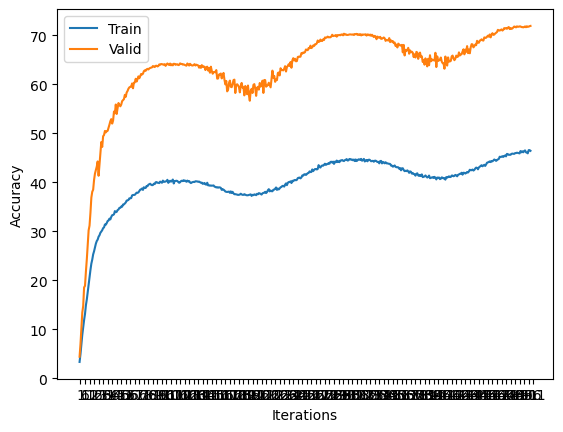

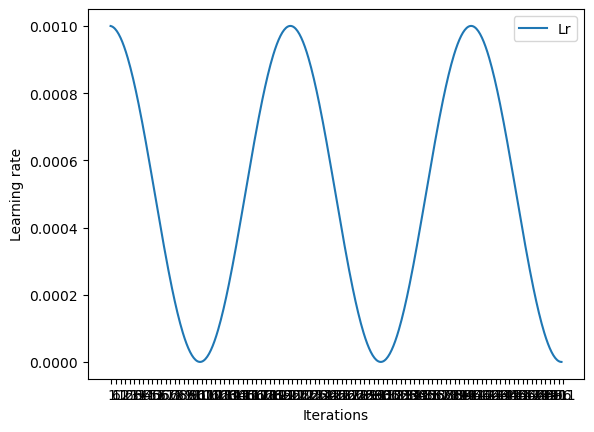

In [18]:
def legend(list_1, label_1, step, title, list_2 = None, label_2 = None):

    plt.plot(list_1[1:], label = label_1)

    if list_2 is not None:
        plt.plot(list_2[1:], label = label_2)

    plt.xticks(range(1, NUM_EPOCHS + step, step))
    plt.xlabel('Iterations')
    plt.ylabel(title)

    plt.legend()
    plt.show()

legend(list_1 = train_losses, label_1 = 'Train', step = 5, title = 'Loss', list_2 = val_losses, label_2 = 'Valid')
legend(list_1 = train_accuracy, label_1 = 'Train', step = 5, title = 'Accuracy', list_2 = val_accuracy, label_2 = 'Valid')
legend(list_1 = lr, label_1 = 'Lr', step = 5, title = 'Learning rate')

# Torch to ONNX

In [19]:
x = torch.randn(2, 5796, requires_grad=True).to("cuda")
# torch_out = torch_model(x)

model = model.to("cuda")

torch.onnx.export(model,               
                  x,                   
                  "MLP.onnx",   
                  export_params=True,  
                  opset_version=10,    
                  do_constant_folding=True, 
                  input_names = ['input'],  
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},   
                                'output' : {0 : 'batch_size'}})

In [20]:
DROP_Z = False

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET + 21
RIGHT_HAND_OFFSET = POSE_OFFSET + 33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [
    61,
    185,
    40,
    39,
    37,
    0,
    267,
    269,
    270,
    409,
    291,
    146,
    91,
    181,
    84,
    17,
    314,
    405,
    321,
    375,
    78,
    191,
    80,
    81,
    82,
    13,
    312,
    311,
    310,
    415,
    95,
    88,
    178,
    87,
    14,
    317,
    402,
    318,
    324,
    308,
]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET + 21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET + 21))

point_landmarks = [
    item
    for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks]
    for item in sublist
]

LANDMARKS = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS)
if DROP_Z:
    INPUT_SHAPE = (NUM_FRAMES, LANDMARKS * 2)
else:
    INPUT_SHAPE = (NUM_FRAMES, LANDMARKS * 3)

FLAT_INPUT_SHAPE = (INPUT_SHAPE[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE[1]

84


In [21]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(
        tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis
    ) / tf.reduce_sum(
        tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis
    )


def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))


def flatten_means_and_stds(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std = tf_nan_std(x, axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE[1] * 2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

In [22]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
#         print(right_hand_percentage(x))
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

# ONNX to TF

In [23]:
tf_model_path = "tf_MLP"
onnx_asl_module = onnx.load("MLP.onnx")
tf_rep = prepare(onnx_asl_module)
tf_rep.export_graph(tf_model_path)

In [24]:
class TFModel(tf.Module):
    def __init__(self, tf_model_path):
        super().__init__()

        self.feature_gen = FeatureGen()
        self.model = tf.saved_model.load(tf_model_path)
        self.feature_gen.trainable = False
        self.model.trainable = False

    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name="inputs")
        ]
    )
    def call(self, input):
        output_tensors = {}
        features = self.feature_gen(tf.cast(input, dtype=tf.float32))

        output_tensors["outputs"] = self.model(**{"input": features})["output"][0, :]

        return output_tensors


mytfmodel = TFModel("./tf_MLP")
tf.saved_model.save(
    mytfmodel, "tf_infer_model", signatures={"serving_default": mytfmodel.call}
)

# TF to TFlite

In [25]:
tf_infer_model_path = "./tf_infer_model"
converter = tf.lite.TFLiteConverter.from_saved_model(tf_infer_model_path)
tflite_model = converter.convert()

tflite_model_path = "model.tflite"

# Save the model
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

In [26]:
!zip submission.zip $tflite_model_path

  adding: model.tflite (deflated 7%)


# Video recording to test the model

### We made this part so that each reader can play with the model and use the camera to determine the gesture on the video.

In [27]:
def format_timedelta(td):

    result = str(td)

    try:
        result, ms = result.split(".")
        
    except ValueError:
        return result + ".00".replace(":", "-")
    
    ms = int(ms)
    ms = round(ms / 1e4)

    return f"{result}.{ms:02}".replace(":", "-")

In [1]:
def get_saving_frames_durations(cap, saving_fps):

    s = []
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)

    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)

    return s

In [29]:
def cut_video(inp_dir):

    SAVING_FRAMES_PER_SECOND = 10

    video     = inp_dir
    filename  = video
    filename += "-opencv"

    if not os.path.isdir(filename):
        os.mkdir(filename)

    cap = cv2.VideoCapture(video)
    fps = cap.get(cv2.CAP_PROP_FPS)

    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)

    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)

    count = 0
    while True:
        is_read, frame = cap.read()

        if not is_read:
            break

        frame_duration = count / fps

        try:
            closest_duration = saving_frames_durations[0]

        except IndexError:
            break

        if frame_duration >= closest_duration:
            frame_duration_formatted = format_timedelta(timedelta(seconds = frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame)

            try:
                saving_frames_durations.pop(0)

            except IndexError:
                pass

        count += 1

    return filename

In [30]:
def create_test_df(input_dir):

    mp_holistic = mp.solutions.holistic
    mp_drawing  = mp.solutions.drawing_utils

    face_list       = []
    left_hand_list  = []
    right_hand_list = []
    pose_list       = []

    iter_f = 0

    for filename in os.listdir(input_dir):
        fil_n = input_dir + '/' + filename

        image = cv2.imread(fil_n)

        ## Setup mediapipe instance
        with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

            # Recolor image to RGB
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = holistic.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # 1. Draw face landmarks
            mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                        mp_drawing.DrawingSpec(color = (80, 110, 10), thickness = 1, circle_radius = 1),
                                        mp_drawing.DrawingSpec(color = (80, 256, 121), thickness = 1, circle_radius = 1)
                                        )

            # 2. Right hand
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color = (80, 22, 10), thickness = 2, circle_radius = 4),
                                        mp_drawing.DrawingSpec(color = (80, 44, 121), thickness = 2, circle_radius = 2)
                                        )

            # 3. Left Hand          
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color = (121, 22, 76), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color = (121, 44, 250), thickness=2, circle_radius=2)
                                        )

            # 4. Draw pose landmarks           
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                        )

        # 1. Face Dataframe
        len_face = 468

        for itr in range(len_face):
            if results.face_landmarks:
                lst = [iter_f, 'face', itr, results.face_landmarks.landmark[itr].x,
                       results.face_landmarks.landmark[itr].y, results.face_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'face', itr, None,None,None]

            face_list.append(lst)

        # 2. Left_hand Dataframe
        len_lft = 21

        for itr in range(len_lft):
            if results.left_hand_landmarks:
                lst = [iter_f, 'left_hand', itr, results.left_hand_landmarks.landmark[itr].x,
                       results.left_hand_landmarks.landmark[itr].y, results.left_hand_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'left_hand', itr, None,None,None]

            left_hand_list.append(lst)

        # 3. Right_hand Dataframe
        len_rgt = 21

        for itr in range(len_rgt):
            if results.right_hand_landmarks:
                lst = [iter_f, 'right_hand', itr, results.right_hand_landmarks.landmark[itr].x,
                       results.right_hand_landmarks.landmark[itr].y, results.right_hand_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'right_hand', itr, None,None,None]

            right_hand_list.append(lst)


        # 2. Pose Dataframe
        len_pose = 33

        for itr in range(len_pose):
            if results.pose_landmarks:
                lst = [iter_f, 'pose', itr, results.pose_landmarks.landmark[itr].x,
                       results.pose_landmarks.landmark[itr].y, results.pose_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'pose', itr, None,None,None]

            pose_list.append(lst)

        iter_f += 1

    df_face       = pd.DataFrame(face_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df_left_hand  = pd.DataFrame(left_hand_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df_right_hand = pd.DataFrame(right_hand_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df_pose       = pd.DataFrame(pose_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df            = pd.concat([df_face, df_left_hand, df_right_hand, df_pose], ignore_index = True)

    return df

In [31]:
def create_video():

    cap = cv2.VideoCapture(0)
    cap.set(3, 640)
    cap.set(4, 480)

    out = cv2.VideoWriter('output.mp4', 0x7634706d, 30.0, (640, 480))

    while True:
        
        _, frame = cap.read()
        out.write(frame)
        cv2.imshow('frame', frame)
        c = cv2.waitKey(1)

        if c & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return out

In [32]:
def get_dataframe():

    if os.path.isdir('./output.mp4-opencv'):
        shutil.rmtree('./output.mp4-opencv')

    create_video() 
    video = 'output.mp4'

    inp_dir = cut_video(video)

    return create_test_df(inp_dir)

In [33]:
model.eval()
lms = get_dataframe()

data = lms[['x', 'y', 'z']]
data = data.fillna(0)
data = data.to_numpy(dtype = 'float')
data = data.reshape(1, -1, MAX_ROWS, 3)
data = torch.tensor(data[:, :MAX_FRAMES, :, :]).float().to(DEVICE)

output = model(data)
_, label = torch.max(output, 1)

label = label.cpu().item()

In [34]:
show_frames_seq(lms, id_2_sign_map[label], lms['frame'][0], 5)